直方图计算

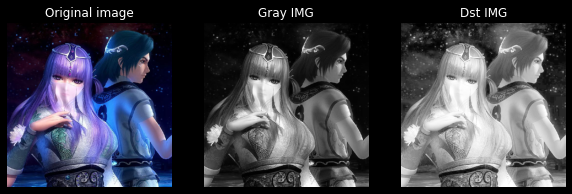

In [11]:

import cv2
import matplotlib.pyplot as plt

#原图
img = cv2.imread('my.jpg')

#转换单通道灰度图
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
 
#均衡化
dst = cv2.equalizeHist(gray)

fig = plt.figure(figsize=(10,7))
plt.subplot(231), plt.title("Original image"), plt.axis('off')
b,g,r = cv2.split(img)
img2 = cv2.merge([r,g,b])
plt.imshow(img2)  # 原始图像
plt.subplot(232), plt.title("Gray IMG"), plt.axis('off')
plt.imshow(gray, cmap='gray')  
plt.subplot(233), plt.title("Dst IMG"), plt.axis('off')
plt.imshow(dst, cmap='gray')  

plt.show()

计算直方图均衡前后对应的熵

In [7]:
import numpy as np

def calc_array(img):
    a= [i  for i in range(256)]

    hist_cv = cv2.calcHist([img],[0],None,[256],[0,256]) #[0,256]的范围是0~255.返回值是每个灰度值出现的次数
    
    P= hist_cv/(len(img)*len(img[0]))  #概率
    

    E = np.sum([p *np.log2(1/p) for p in P if p!=0])
    print(E) #熵

calc_array(gray)
calc_array(dst)

7.382983577638941
7.110025201530739


RGB重新均衡化，与图一的结果作比较

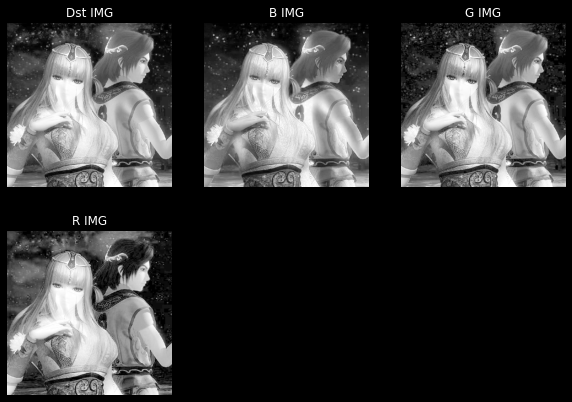

In [9]:
b,g,r = cv2.split(img)
#均衡化
dstb = cv2.equalizeHist(b)
#均衡化
dstg = cv2.equalizeHist(g)
#均衡化
dstr = cv2.equalizeHist(r)

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,7))
plt.subplot(231), plt.title("Dst IMG"), plt.axis('off')
plt.imshow(dst, cmap='gray')  # 原始图像
plt.subplot(232), plt.title("B IMG"), plt.axis('off')
plt.imshow(dstb, cmap='gray')  
plt.subplot(233), plt.title("G IMG"), plt.axis('off')
plt.imshow(dstg, cmap='gray')  
plt.subplot(234), plt.title("R IMG"), plt.axis('off')
plt.imshow(dstr, cmap='gray') 
plt.show()

对lena进行直方图均衡化，并计算前后对比度

In [39]:
img_lena = cv2.imread('lena.bmp')
#灰度化
gray_lena = cv2.cvtColor(img_lena, cv2.COLOR_BGR2GRAY)
#均衡化
dst_lena = cv2.equalizeHist(gray_lena)

#对比度计算
def contrast(img):   
    # img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #彩色转为灰度图片
    m, n = img.shape
    #图片矩阵向外扩展一个像素
    img1_ext = cv2.copyMakeBorder(img,1,1,1,1,cv2.BORDER_REPLICATE) / 1.0   # 除以1.0的目的是uint8转为float型，便于后续计算
    rows_ext,cols_ext = img1_ext.shape
    b = 0.0
    for i in range(1,rows_ext-1):
        for j in range(1,cols_ext-1):
            b += ((img1_ext[i,j]-img1_ext[i,j+1])**2 + (img1_ext[i,j]-img1_ext[i,j-1])**2 + 
                    (img1_ext[i,j]-img1_ext[i+1,j])**2 + (img1_ext[i,j]-img1_ext[i-1,j])**2)

    cg = b/(4*(m-2)*(n-2)+3*(2*(m-2)+2*(n-2))+2*4) #对应上面48的计算公式
    print(cg)
contrast(dst_lena)
contrast(gray_lena)

462.7702588848039
330.72185968137256


进行直方图匹配，并比较结果

In [40]:
# 计算累计直方图
histImg, bins = np.histogram(gray.flatten(), 256)  # 计算原始图像直方图
histRef, bins = np.histogram(gray_lena.flatten(), 256)  # 计算匹配模板直方图
cdfImg = histImg.cumsum()  # 计算原始图像累积分布函数 CDF
cdfRef = histRef.cumsum()  # 计算匹配模板累积分布函数 CDF
# 计算直方图匹配转换函数
transM = np.zeros(256)
for i in range(256):
    index = 0
    vMin = np.fabs(cdfImg[i] - cdfRef[0])
    for j in range(256):
        diff = np.fabs(cdfImg[i] - cdfRef[j])
        if (diff < vMin):
            index = int(j)
            vMin = diff
    transM[i] = index

# 直方图匹配
# imgOut = np.zeros_like(img)
imgOut = transM[gray].astype(np.uint8)
